# Text Detection and Recognition Demo

In this notebook we will try to build an OCR pipeline given only the text detection and recognition model. We will be using MMOCR.

## Dependencies Setup

In [1]:
!pip install torch==1.13.1+cu117 \
  torchvision==0.14.1+cu117 \
  --extra-index-url https://download.pytorch.org/whl/cu117
!pip install -U openmim
!mim install "mmengine>=0.7.1,<1.1.0"
!mim install "mmcv>=2.0.0rc4,<2.1.0"
!mim install "mmdet>=3.0.0rc5,<3.2.0"
!git clone https://github.com/open-mmlab/mmocr.git
!cd mmocr && pip install -v -e .

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117
Looking in links: https://download.openmmlab.com/mmcv/dist/cu117/torch1.13.0/index.html
Looking in links: https://download.openmmlab.com/mmcv/dist/cu117/torch1.13.0/index.html
Looking in links: https://download.openmmlab.com/mmcv/dist/cu117/torch1.13.0/index.html
fatal: destination path 'mmocr' already exists and is not an empty directory.
Using pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
Obtaining file:///content/mmocr
  Running command python setup.py egg_info
  running egg_info
  creating /tmp/pip-pip-egg-info-fymtvyky/mmocr.egg-info
  writing manifest file '/tmp/pip-pip-egg-info-fymtvyky/mmocr.egg-info/SOURCES.txt'
  writing manifest file '/tmp/pip-pip-egg-info-fymtvyky/mmocr.egg-info/SOURCES.txt'
  Preparing metadata (setup.py) ... done
  Attempting uninstall: mmocr
    Found existing installation: mmocr 1.0.1
    Uninstalling mmocr-1.0.1:
      Removing file or direct

In [2]:
!pip install Levenshtein

In [3]:
!pip install pyspellchecker

In [4]:
!pip install jiwer

In [5]:
from google.colab import drive
# Mount Google Drive to /content/gdrive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Download the CTW 1500 dataset for test images

Download model weights

In [6]:
!wget https://download.openmmlab.com/mmocr/textdet/textsnake/textsnake_resnet50_fpn-unet_1200e_ctw1500/textsnake_resnet50_fpn-unet_1200e_ctw1500_20220825_221459-c0b6adc4.pth
!wget https://download.openmmlab.com/mmocr/textrecog/svtr/svtr-base_20e_st_mj/svtr-base_20e_st_mj-ea500101.pth
!wget https://download.openmmlab.com/mmocr/textdet/dbnetpp/dbnetpp_resnet50_fpnc_1200e_icdar2015/dbnetpp_resnet50_fpnc_1200e_icdar2015_20221025_185550-013730aa.pth
!wget https://download.openmmlab.com/mmocr/textrecog/abinet/abinet-vision_20e_st-an_mj/abinet-vision_20e_st-an_mj_20220915_152445-85cfb03d.pth

--2024-01-26 15:56:54--  https://download.openmmlab.com/mmocr/textdet/textsnake/textsnake_resnet50_fpn-unet_1200e_ctw1500/textsnake_resnet50_fpn-unet_1200e_ctw1500_20220825_221459-c0b6adc4.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 163.181.66.107, 163.181.66.110, 163.181.66.104, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|163.181.66.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162448974 (155M) [application/octet-stream]
Saving to: ‘textsnake_resnet50_fpn-unet_1200e_ctw1500_20220825_221459-c0b6adc4.pth.2’

textsnake_resnet50_ 100%[===================>] 154.92M  39.5MB/s    in 4.8s    

2024-01-26 15:57:00 (32.5 MB/s) - ‘textsnake_resnet50_fpn-unet_1200e_ctw1500_20220825_221459-c0b6adc4.pth.2’ saved [162448974/162448974]

--2024-01-26 15:57:00--  https://download.openmmlab.com/mmocr/textrecog/svtr/svtr-base_20e_st_mj/svtr-base_20e_st_mj-ea500101.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 16

In [7]:
### Text Detections
TEXTSNAKE_CTW = {
    "config": "/content/mmocr/configs/textdet/textsnake/textsnake_resnet50_fpn-unet_1200e_ctw1500.py",
    "weights": "/content/textsnake_resnet50_fpn-unet_1200e_ctw1500_20220825_221459-c0b6adc4.pth"
}
DBNETPP_IC15 = {
    "config": "/content/mmocr/configs/textdet/dbnetpp/dbnetpp_resnet50_fpnc_1200e_icdar2015.py",
    "weights": "/content/dbnetpp_resnet50_fpnc_1200e_icdar2015_20221025_185550-013730aa.pth"
}
TEXT_DET_CUSTOM = {
    "config": "/content/gdrive/MyDrive/TextDetection_dbnet_training/TextDetection_dbnet_training/dbnet_resnet50-dcnv2_fpnc_1200e_icdar2015.py",
    "weights": "/content/gdrive/MyDrive/TextDetection_dbnet_training/TextDetection_dbnet_training/epoch_70.pth"
}

### Text Recognition
SVTR_SYNTH = {
    "config": "/content/mmocr/configs/textrecog/svtr/svtr-base_20e_st_mj.py",
    "weights": "/content/svtr-base_20e_st_mj-ea500101.pth"
}
ABI_SYNTH = {
    "config": "/content/mmocr/configs/textrecog/abinet/abinet-vision_20e_st-an_mj.py",
    "weights": "/content/abinet-vision_20e_st-an_mj_20220915_152445-85cfb03d.pth"
}
TEXT_RECOG_CUSTOM = {
    "config": "/content/gdrive/MyDrive/TextRecognition_svtr_training/TextRecognition_svtr_training/svtr-base_20e_st_mj.py",
    "weight": "/content/gdrive/MyDrive/TextRecognition_svtr_training/TextRecognition_svtr_training/epoch_20.pth"
}

Import packages!

In [8]:
import cv2
import matplotlib.pyplot as plt
import mmcv
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle
from mmocr.apis import TextDetInferencer, TextRecInferencer

## Text Detection

Let's try the text detector. Try both TextSnake and DBnet++ models.

In [26]:
IMAGE_TEST = "/content/4.jpg"
MODEL = TEXT_DET_CUSTOM

inferencer = TextDetInferencer(model=MODEL["config"], weights=MODEL["weights"])
result = inferencer(IMAGE_TEST)

Loads checkpoint by local backend from path: /content/gdrive/MyDrive/TextDetection_dbnet_training/TextDetection_dbnet_training/epoch_70.pth
01/26 16:02:57 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
01/26 16:02:57 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
01/26 16:02:57 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
01/26 16:02:57 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
01/26 16:02:57 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
01/26 16:02:57 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
01/26 16:02:57 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
01/26 16:02:57 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to

Output()

/usr/local/lib/python3.10/dist-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '
/usr/local/lib/python3.10/dist-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.TensorboardVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


In [27]:
# IMAGE_TEST = "/content/4.jpg"
# MODEL = DBNETPP_IC15

# inferencer = TextDetInferencer(model=MODEL["config"], weights=MODEL["weights"])
# result = inferencer(IMAGE_TEST)

Take a look at the raw inference results

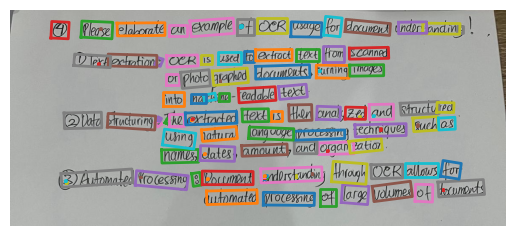

In [28]:
fig, ax = plt.subplots()
ax.imshow(mmcv.imread(IMAGE_TEST, channel_order="rgb"))
for poly in result["predictions"][0]["polygons"]:
  c = np.array(poly).astype(int).reshape((-1, 2))
  c = np.concatenate((c, c[0].reshape((-1, 2))))
  ax.plot(c[:, 0], c[:, 1], linewidth=2)
ax.axis("off")
plt.show()

To simplify processing, we can convert the polygon into rectangle

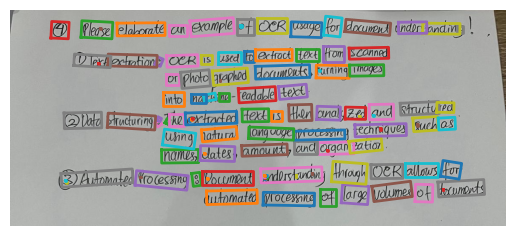

In [29]:
fig, ax = plt.subplots()
ax.imshow(mmcv.imread(IMAGE_TEST, channel_order="rgb"))
for poly in result["predictions"][0]["polygons"]:
  c = np.array(poly).astype(int).reshape((-1, 2))
  rect = cv2.minAreaRect(c)
  box = cv2.boxPoints(rect)
  box = np.concatenate((box, box[0].reshape((-1, 2))))
  ax.plot(box[:, 0], box[:, 1], linewidth=2)
ax.axis("off")
plt.show()

Or, we can just convert them to non-rotated bounding box, by taking the min-max of the x and y coordinates.

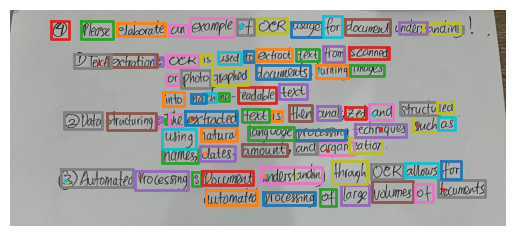

In [30]:
fig, ax = plt.subplots()
ax.imshow(mmcv.imread(IMAGE_TEST, channel_order="rgb"))
for poly in result["predictions"][0]["polygons"]:
  c = np.array(poly).astype(int).reshape((-1, 2))
  x1 = np.min(c[:, 0])
  x2 = np.max(c[:, 0])
  y1 = np.min(c[:, 1])
  y2 = np.max(c[:, 1])
  box = np.array(
    [
      [x1, y1],
      [x1, y2],
      [x2, y2],
      [x2, y1],
      [x1, y1]
    ]
  )
  ax.plot(box[:, 0], box[:, 1], linewidth=2)
ax.axis("off")
plt.show()

## Text Recognition

Let's try out the text recognition model. We will use SVTR model, which is one of the latest text recognition model.

But first, let's for the detection again.

In [31]:
IMAGE_TEST = "/content/4.jpg"
DET_MODEL = TEXT_DET_CUSTOM

img = mmcv.imread(IMAGE_TEST, channel_order="rgb")
inferencer = TextDetInferencer(model=DET_MODEL["config"], weights=DET_MODEL["weights"])
det_result = inferencer(img)
polys_raw = det_result["predictions"][0]["polygons"]

Loads checkpoint by local backend from path: /content/gdrive/MyDrive/TextDetection_dbnet_training/TextDetection_dbnet_training/epoch_70.pth
01/26 16:03:00 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
01/26 16:03:00 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
01/26 16:03:00 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
01/26 16:03:00 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
01/26 16:03:00 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
01/26 16:03:00 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
01/26 16:03:00 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
01/26 16:03:00 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to

Output()

In [32]:
# IMAGE_TEST = "/content/4.jpg"
# DET_MODEL = DBNETPP_IC15

# img = mmcv.imread(IMAGE_TEST, channel_order="rgb")
# inferencer = TextDetInferencer(model=DET_MODEL["config"], weights=DET_MODEL["weights"])
# det_result = inferencer(img)
# polys_raw = det_result["predictions"][0]["polygons"]

We will convert the polygon to 4 vertices polygon, so that it is easier to convert the angled text image into flat image.

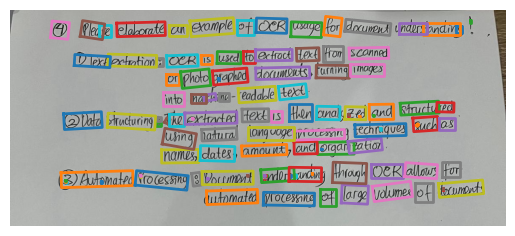

In [33]:
polys = []
for poly in polys_raw:
  c = np.array(poly).astype(int).reshape((-1, 2))
  rect = cv2.minAreaRect(c)
  box = cv2.boxPoints(rect)
  polys.append(box)

fig, ax = plt.subplots()
ax.imshow(img)
for poly in polys:
  c = np.concatenate((poly, poly[0].reshape((-1, 2))))
  ax.plot(c[:, 0], c[:, 1], linewidth=2)
ax.axis("off")
plt.show()

Crop the text images, and transform them into flat rectange image.

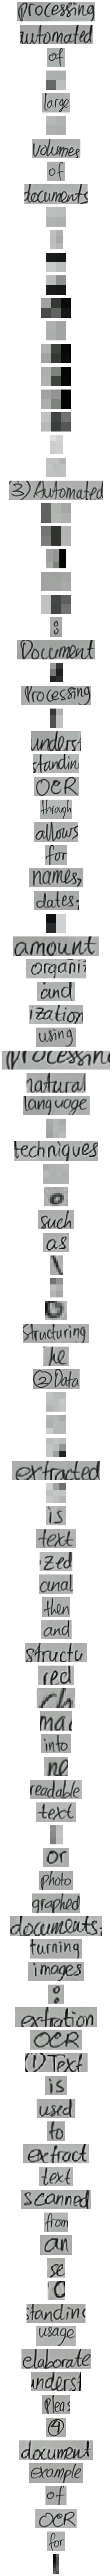

In [34]:
def organize_points(rect):
  """
  Sort 4 vertices polygon into the same order
  [top-left, top-right, bottom-right, bottom-left]
  """
  # sort points based on the x coordinate
  # so the order now [left-1, left-2, right-1, right-2]
  # we don't know which one is top or bottom yet
  points = sorted(list(rect), key=lambda x: x[0])
  # for 2 left points
  # the point with smaller y become top-left
  if points[1][1] > points[0][1]:
      index_1 = 0
      index_4 = 1
  else:
      index_1 = 1
      index_4 = 0
  # for 2 right points
  # the point with smaller y become top-right
  if points[3][1] > points[2][1]:
      index_2 = 2
      index_3 = 3
  else:
      index_2 = 3
      index_3 = 2

  return np.array([
      points[index_1], points[index_2], points[index_3], points[index_4]
  ])

def extract_text_image(rect, img):
  """
  Given 4 vertices polygon, crop the image using that
  polygon, and transform the crop so that it is flat.
  """
  # get the top-left, top-right, bottom-right, and bottom-left points.
  rect = organize_points(rect)
  tl, tr, br, bl = rect

  # determine the flattened image width,
  # which is equal to the largest bottom/top side of the polygon
  widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
  widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
  maxWidth = max(int(widthA), int(widthB))

  # determine the flattened image height,
  # which is equal to the largest left/right side of the polygon
  heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
  heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
  maxHeight = max(int(heightA), int(heightB))

  # create the 4 vertices polygon after transformation
  dst = np.array(
    [
      [0, 0],
      [maxWidth - 1, 0],
      [maxWidth - 1, maxHeight - 1],
      [0, maxHeight - 1],
    ],
    dtype=np.float32,
  )
  # do the transformation
  M = cv2.getPerspectiveTransform(rect, dst)
  return cv2.warpPerspective(img, M, (maxWidth, maxHeight))

text_images = [extract_text_image(poly, img) for poly in polys]
fig, axs = plt.subplots(len(text_images), figsize=(5, len(text_images)*1), tight_layout=True)
for i, txt_img in enumerate(text_images):
  axs[i].imshow(txt_img)
  axs[i].axis("off")
plt.show()

Now we already have the text images, let's try running the inference of the text recognition

In [35]:
REC_MODEL = TEXT_RECOG_CUSTOM
inferencer = TextRecInferencer(
    model="/content/gdrive/MyDrive/TextRecognition_svtr_training/TextRecognition_svtr_training/svtr-base_20e_st_mj.py",
    weights="/content/gdrive/MyDrive/TextRecognition_svtr_training/TextRecognition_svtr_training/epoch_20.pth")

text_images = []
texts = []
for poly in polys:
  poly_arr = np.array(poly).reshape((-1, 2)).astype(np.float32)
  txt_img = extract_text_image(poly_arr, img)
  rec_result = inferencer(txt_img)
  text_images.append(txt_img)
  texts.append(rec_result["predictions"][0]["text"])

Loads checkpoint by local backend from path: /content/gdrive/MyDrive/TextRecognition_svtr_training/TextRecognition_svtr_training/epoch_20.pth


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

In [36]:
# REC_MODEL = SVTR_SYNTH
# inferencer = TextRecInferencer(
#     model="/content/mmocr/configs/textrecog/svtr/svtr-base_20e_st_mj.py",
#     weights="/content/svtr-base_20e_st_mj-ea500101.pth")

# text_images = []
# texts = []
# for poly in polys:
#   poly_arr = np.array(poly).reshape((-1, 2)).astype(np.float32)
#   txt_img = extract_text_image(poly_arr, img)
#   rec_result = inferencer(txt_img)
#   text_images.append(txt_img)
#   texts.append(rec_result["predictions"][0]["text"])

Visualize!

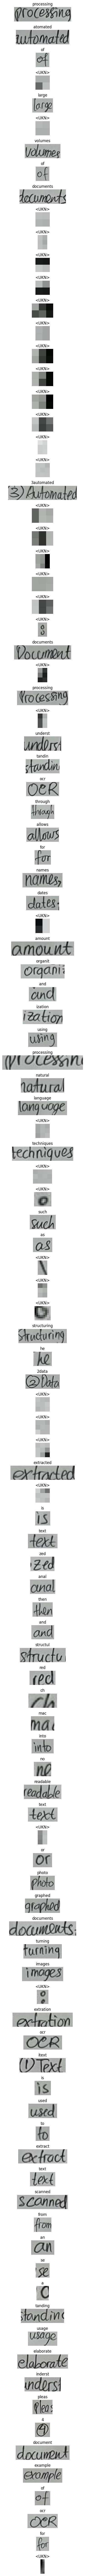

In [37]:
fig, axs = plt.subplots(len(texts), figsize=(5, len(texts)*1), tight_layout=True)
for i, txt in enumerate(texts):
  axs[i].imshow(text_images[i])
  axs[i].set_title(txt)
  axs[i].axis("off")
plt.show()

In [38]:
texts

['processing',
 'atomated',
 'of',
 '<UKN>',
 'large',
 '<UKN>',
 'volumes',
 'of',
 'documents',
 '<UKN>',
 '<UKN>',
 '<UKN>',
 '<UKN>',
 '<UKN>',
 '<UKN>',
 '<UKN>',
 '<UKN>',
 '<UKN>',
 '<UKN>',
 '<UKN>',
 '<UKN>',
 '3automated',
 '<UKN>',
 '<UKN>',
 '<UKN>',
 '<UKN>',
 '<UKN>',
 '<UKN>',
 'documents',
 '<UKN>',
 'processing',
 '<UKN>',
 'underst',
 'tandin',
 'ocr',
 'through',
 'allows',
 'for',
 'names',
 'dates',
 '<UKN>',
 'amount',
 'organit',
 'and',
 'ization',
 'using',
 'processing',
 'natural',
 'language',
 '<UKN>',
 'techniques',
 '<UKN>',
 '<UKN>',
 'such',
 'as',
 '<UKN>',
 '<UKN>',
 '<UKN>',
 'structuring',
 'he',
 '2data',
 '<UKN>',
 '<UKN>',
 '<UKN>',
 'extracted',
 '<UKN>',
 'is',
 'text',
 'zed',
 'anal',
 'then',
 'and',
 'structul',
 'red',
 'ch',
 'mac',
 'into',
 'no',
 'readable',
 'text',
 '<UKN>',
 'or',
 'photo',
 'graphed',
 'documents',
 'turning',
 'images',
 '<UKN>',
 'extration',
 'ocr',
 'itext',
 'is',
 'used',
 'to',
 'extract',
 'text',
 'scanned

In [39]:
texts_1 = [value.replace('<UKN>', '') if isinstance(value, str) and value != '<UKN>' else '' for value in texts]
texts_1 = list(filter(None, texts_1))

In [40]:
from spellchecker import SpellChecker

def spell_check_result(ocr_result):
    # Create a SpellChecker instance
    spell = SpellChecker()

    # Join the OCR result list into a space-separated string
    text = ' '.join(ocr_result)

    # Tokenize the text into words
    words = text.split()

    # Perform spell checking on each word, excluding None values
    corrected_words = [spell.correction(word) for word in words if word and spell.correction(word)]

    # Join the corrected words into a space-separated string
    corrected_text = ' '.join(corrected_words)

    return corrected_text

In [41]:
import pandas as pd
import Levenshtein

# Read the ground truth text from 4.txt
with open('4.txt', 'r') as file:
    ground_truth_4 = file.read().strip()

# Create a DataFrame with scalar values
df = pd.DataFrame({
    'Original Text': ground_truth_4,
    'Reference Text Default Model': spell_check_result(texts_2),
    'Reference Text Trained Model': spell_check_result(texts_1),
    'CER Default': [Levenshtein.distance(ground_truth_4, spell_check_result(texts_2))],
    'CER Trained': [Levenshtein.distance(ground_truth_4, spell_check_result(texts_1))],
    'WER Default': [Levenshtein.distance(ground_truth_4.split(), spell_check_result(texts_2).split())],
    'WER Trained': [Levenshtein.distance(ground_truth_4.split(), spell_check_result(texts_1).split())]
})

# Display the DataFrame
df

Original Text  \
0  4. Please elaborate an example of OCR usage fo...   

                        Reference Text Default Model  \
0  processing automated of large volumes document...   

                        Reference Text Trained Model  CER Default  \
0  processing automated of large volumes of docum...          332   

   CER Trained  WER Default  WER Trained  
0          350           68           74